In [30]:
# 3) 오존량 예측

import pandas as pd

df = pd.read_csv("c:/data/ozone/ozone2.csv")
df

,Month,Day,Solar.R,Wind,Temp,Ozone,Result
0,5,1,190.000000,7.4,67,41,0
1,5,2,118.000000,8.0,72,36,0
2,5,3,149.000000,12.6,74,12,0
3,5,4,313.000000,11.5,62,18,0
4,5,5,185.931507,14.3,56,42,1
...,...,...,...,...,...,...,...
148,9,26,193.000000,6.9,70,30,0
149,9,27,145.000000,13.2,77,42,1
150,9,28,191.000000,14.3,75,14,0
151,9,29,131.000000,8.0,76,18,0


<Axes: >

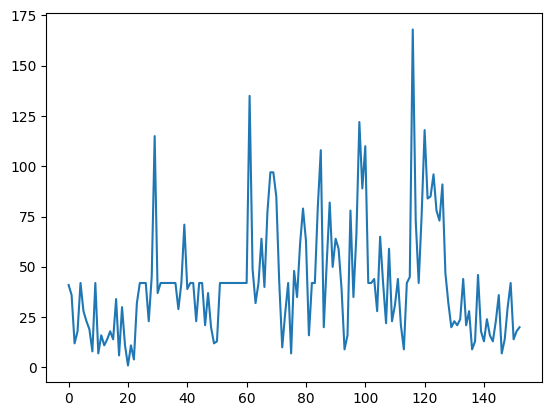

In [31]:
df["Ozone"].plot()

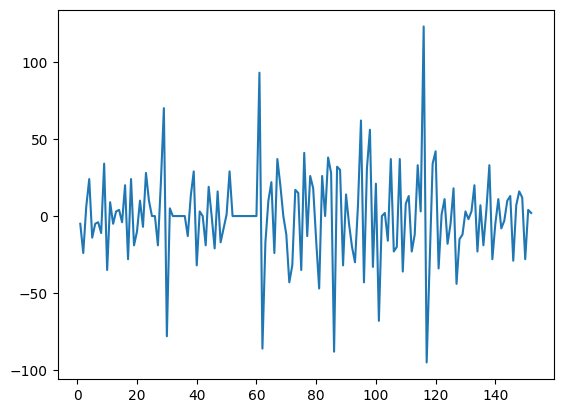

In [32]:
# 1차 차분 데이터
import matplotlib.pyplot as plt

diff1 = df["Ozone"].diff(periods=1).iloc[1:]
diff1.plot()
plt.show()

In [33]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

# 로그 후 차분한 자료를 adfuller 함수로 안정적인 시계열인지 확인

diff1 = np.log(df["Ozone"]).diff(periods=1).iloc[1:]
result = adfuller(diff1)
print(result)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])

# p-value가 0.05보다 작으므로 95% 신뢰수준 하에서 유의함(안정적인 시계열 자료임)

(-9.192299287680047, 2.1073328851652093e-15, 3, 148, {'1%': -3.4753253063120644, '5%': -2.881274703275226, '10%': -2.5772928360116873}, 289.50077473624015)
ADF Statistic: -9.192299
p-value: 0.000000


In [34]:
from pmdarima.arima import auto_arima

model = auto_arima(df["Ozone"], suppress_warnings=True)
model

# 가장 적절한 모형은 arima(1,0,1)

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

In [35]:
# 학습용,검증용 구분
n = int(df.shape[0] * 0.8)
train = df[:n]
test = df[:n]
print(len(df["Ozone"]))
print(train["Ozone"].values)
print(test["Ozone"].values)

153
[ 41  36  12  18  42  28  23  19   8  42   7  16  11  14  18  14  34   6
  30  11   1  11   4  32  42  42  42  23  45 115  37  42  42  42  42  42
  42  29  42  71  39  42  42  23  42  42  21  37  20  12  13  42  42  42
  42  42  42  42  42  42  42 135  49  32  42  64  40  77  97  97  85  42
  10  27  42   7  48  35  61  79  63  16  42  42  80 108  20  52  82  50
  64  59  39   9  16  78  35  66 122  89 110  42  42  44  28  65  42  22
  59  23  31  44  21   9  42  45 168  73  42  76 118  84]
[ 41  36  12  18  42  28  23  19   8  42   7  16  11  14  18  14  34   6
  30  11   1  11   4  32  42  42  42  23  45 115  37  42  42  42  42  42
  42  29  42  71  39  42  42  23  42  42  21  37  20  12  13  42  42  42
  42  42  42  42  42  42  42 135  49  32  42  64  40  77  97  97  85  42
  10  27  42   7  48  35  61  79  63  16  42  42  80 108  20  52  82  50
  64  59  39   9  16  78  35  66 122  89 110  42  42  44  28  65  42  22
  59  23  31  44  21   9  42  45 168  73  42  76 118  84]


In [36]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train["Ozone"], order=(1, 0, 1)).fit()

predictions = model.predict(start=1, end=len(test), dynamic=False)
predictions.index = len(train) + (predictions.index - 1)
predictions

122    43.263794
123    41.217065
124    32.372084
125    31.367439
126    39.182761
         ...    
239    68.672191
240    52.128595
241    57.950685
242    74.255168
243    68.350098
Name: predicted_mean, Length: 122, dtype: float64

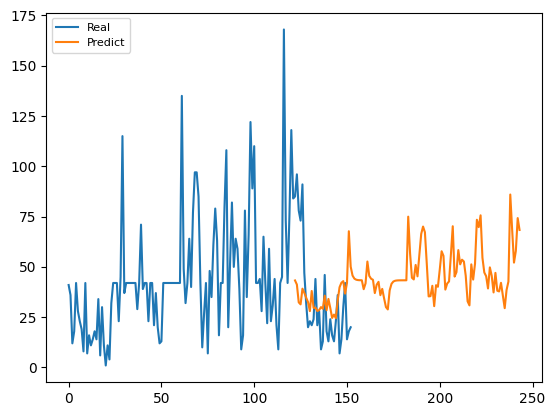

In [37]:
plt.plot(df["Ozone"], label="Real")
plt.plot(predictions, label="Predict")
plt.legend(loc="upper left", fontsize=8)
plt.show()

In [38]:
import numpy as np


def _error(real, pred):
    return real - pred


def mse(real, pred):
    return np.mean(np.square(_error(real, pred)))


def rmse(real, pred):
    return np.sqrt(mse(real, pred))


def mae(real, pred):
    return np.mean(np.abs(_error(real, pred)))


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "mae": mae,
}


def evaluate(real, pred, metrics=("mse", "rmse", "mae")):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](real, pred)
        except:
            results[name] = np.nan
    return results

In [39]:
evaluate(test["Ozone"].values, predictions.values)

{'mse': 318.34855820662005,
 'rmse': 17.842324910353472,
 'mae': 12.444174250567345}